# <center> Training RNNs <center>

To train an RNN, the trick is to unroll it through time (like we just did) and then simply use regular backpropagation (see Figure 14-5). This strategy is called backpropagationthrough time (**BPTT**).

Just like in regular backpropagation, there is a first forward pass through the unrolled network, then the output sequence is evaluated using a cost function $C(Y_{t_{min}}, Y_{t_{min} + 1} , ⋯, Y_{t_{max}})$
(where $t_{min}$ and $t_{max}$ are the first and last output time steps, not counting the ignored outputs), and the gradients of
that cost function are propagated backward through the unrolled network (represented by the solid arrows); and finally the model parameters are updated using the gradients computed during BPTT. 

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Training a Sequence Classifier

Let’s train an RNN to classify MNIST images.

In [2]:
tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [4]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.873333 Test accuracy: 0.9126
1 Train accuracy: 0.926667 Test accuracy: 0.9399
2 Train accuracy: 0.94 Test accuracy: 0.9649
3 Train accuracy: 0.966667 Test accuracy: 0.9607
4 Train accuracy: 0.966667 Test accuracy: 0.9642
5 Train accuracy: 0.973333 Test accuracy: 0.9705
6 Train accuracy: 0.986667 Test accuracy: 0.9728
7 Train accuracy: 1.0 Test accuracy: 0.9695
8 Train accuracy: 0.98 Test accuracy: 0.9728
9 Train accuracy: 0.973333 Test accuracy: 0.975
10 Train accuracy: 0.986667 Test accuracy: 0.975
11 Train accuracy: 0.986667 Test accuracy: 0.9744
12 Train accuracy: 0.993333 Test accuracy: 0.9734
13 Train accuracy: 0.973333 Test accuracy: 0.9768
14 Train accuracy: 0.973333 Test accuracy: 0.9764
15 Train accuracy: 0.986667 Test accuracy: 0.9748
16 Train accuracy: 1.0 Test accuracy: 0.9756
17 Train accuracy: 0.986667 Test accuracy: 0.9779
18 Train accuracy: 0.973333 Test accuracy: 0.9681
19 Train accuracy: 0.98 Test accuracy: 0.9772
20 Train accuracy: 0.98 Test accur

## Training to Predict Time Series

Now let’s take a look at how to handle time series, such as stock prices, air temperature, brain wave patterns, and so on. Let's create a time series:

In [2]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

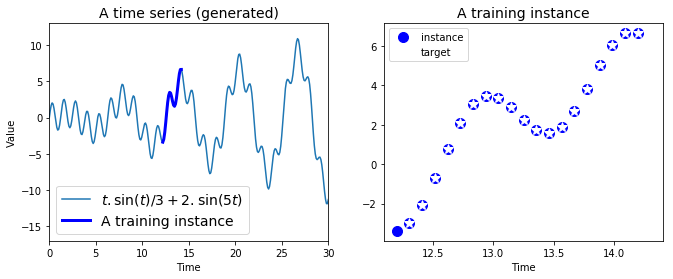

In [5]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


plt.show()

Let's create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each training instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a sigle value:

In [6]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an OutputProjectionWrapper. A cell wrapper acts like a normal cell, proxying
every method call to an underlying cell, but it also adds some functionality. The OutputProjectionWrapper adds a fully connected layer of linear neurons (i.e., without any activation function) on top of each output (but it does not affect the cell state).

In [21]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    saver.save(sess, "./my_time_series_model")

0 	MSE: 15.2348
100 	MSE: 0.651965
200 	MSE: 0.174493
300 	MSE: 0.082367
400 	MSE: 0.0614993
500 	MSE: 0.0487613
600 	MSE: 0.049408
700 	MSE: 0.0557656
800 	MSE: 0.043733
900 	MSE: 0.0477108
1000 	MSE: 0.0529085
1100 	MSE: 0.0411521
1200 	MSE: 0.0480515
1300 	MSE: 0.0422694
1400 	MSE: 0.0410173


In [22]:
with tf.Session() as sess:   
    saver.restore(sess, "./my_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


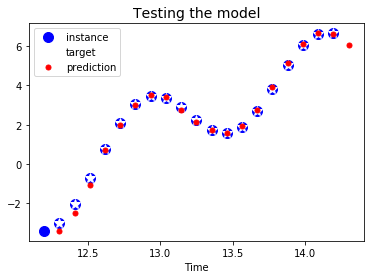

In [24]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

Although using an OutputProjectionWrapper is the simplest solution to reduce the dimensionality of the RNN’s output sequences down to just one value per time step (per instance), it is not the most efficient. There is a trickier but more efficient solution:
- you can reshape the RNN outputs from [batch_size, n_steps, n_neurons] to [batch_size * n_steps, n_neurons]
- then apply a single fully connected layer with the appropriate output size (in our case just 1), which will result in an output tensor of shape [batch_size * n_steps, n_outputs]
- and then reshape this tensor to [batch_size, n_steps, n_outputs].

In [26]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    saver.save(sess, "./my_time_series_model")

0 	MSE: 17.3982
100 	MSE: 0.665817
200 	MSE: 0.23147
300 	MSE: 0.113787
400 	MSE: 0.0657144
500 	MSE: 0.0541521
600 	MSE: 0.0587217
700 	MSE: 0.0553434
800 	MSE: 0.0526671
900 	MSE: 0.0548202
1000 	MSE: 0.0458866
1100 	MSE: 0.05492
1200 	MSE: 0.0472552
1300 	MSE: 0.0475582
1400 	MSE: 0.0448903


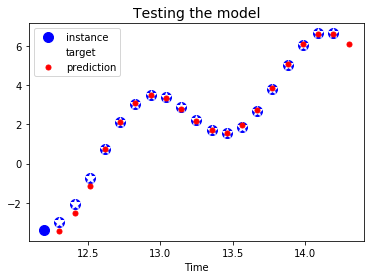

In [27]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a creative new sequence

Moreover, RNNs’ ability to anticipate also makes them capable of surprising creativity. You can ask them to predict which are the most likely next notes in a melody, then randomly pick one of these notes and play it. Then ask the net for the next most likely notes, play it, and repeat the process again and again. Before you know it, your net will compose a melody such as the one produced by Google’s Magenta project. Similarly, RNNs can generate sentences, image captions, and much more.

Now that we have a model that can predict the future, we can use it to generate some creative sequences. All we need is to provide it a seed sequence containing n_steps values (e.g., full of zeros), use the model to predict the next value, append this predicted value to the sequence, feed the last n_steps values to the model to predict the next value, and so on.

In [30]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


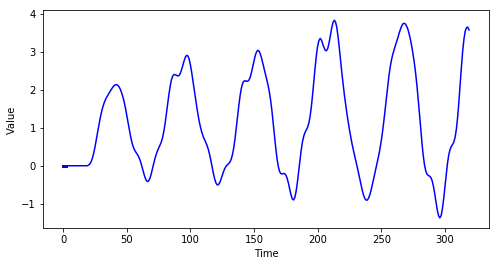

In [31]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()